# `PointProcess` - Example Notebook

Prerequisite:
- Before running this notebook you should build the library by running the build.sh script.
- Make sure that the shared library was created. (e.g. at path build/src/pointprocess.cpython-310-darwin.so)

In [8]:
# Basic imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

In [9]:

# TODO: CHANGE HERE WITH THE PATH TO THE FOLDER CONTAINING YOUR .so (On MacOs and Linux) or .dll (Windows)
PATH_TO_LIB = "../build/" # "build/src/" 
# In my case the generated .so is build/src/pointprocess.cpython-310-darwin.so

sys.path.append(PATH_TO_LIB)

# Now we can import the Python byndings from the pointprocess library
from pointprocess import (
    compute_single_regression,
    compute_full_regression,
    compute_spectral_analysis,
    Distributions,
    Result,
    RegressionResult,
    get_ks_coords
)

Text(0, 0.5, 'RR [ms]')

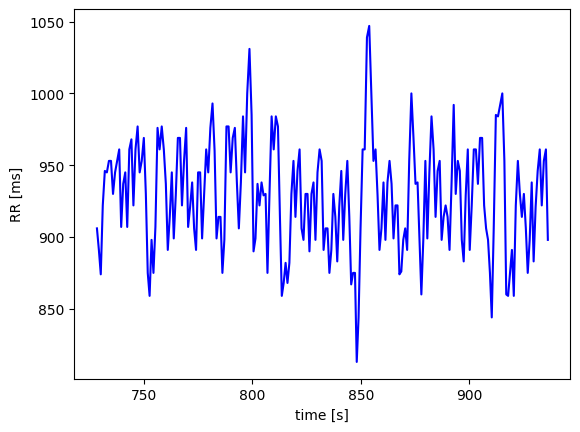

In [ ]:
# Example: load and plot a series of RR events
rr = np.load("events.npy")
events = np.array(rr[75:301])
plt.plot(events[1:], 1000*np.diff(events),"b")
plt.xlabel('time [s]')
plt.ylabel('RR [ms]')

## Single Regression

In [11]:
# Compute single regression on a subset of the RR intervals
result_single_regression = compute_single_regression(
    events = rr[75:301],
    ar_order = 9,
    has_theta0 = True,
    right_censoring = False,
    alpha = 0.02,
    distribution=Distributions.InverseGaussian,
    max_iter=10000
    )

print(
    f"Thetap:        {result_single_regression.thetap}\n"
    f"Theta0:        {result_single_regression.theta0}\n"
    f"Kappa:         {result_single_regression.kappa}\n"
    f"Likelihood:    {result_single_regression.likelihood}\n"
    f"Mean interval: {result_single_regression.mean_interval}"
)

Thetap:        [ 0.74041811 -0.03751152 -0.07736307  0.05236144 -0.54686506  0.04305882
  0.54804709 -0.39545666  0.07596222]
Theta0:        0.5520934692175923
Kappa:         1956.069946895077
Likelihood:    -133.3274819358906
Mean interval: 0.9249388213947649


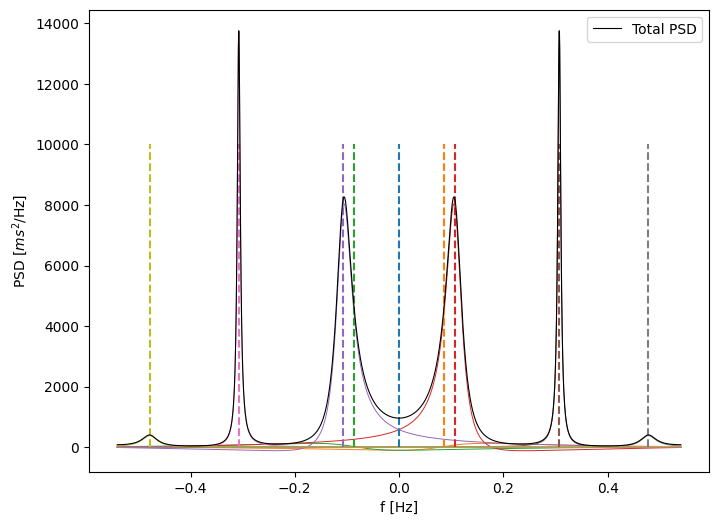

In [12]:
thetap = result_single_regression.thetap
mean_interval = result_single_regression.mean_interval
kappa = result_single_regression.kappa
variance = result_single_regression.sigma**2


# Retrieve spectral info
analysis = compute_spectral_analysis(thetap, mean_interval, variance, aggregate=False)

# Plot stuff
plt.figure(figsize=(8,6),dpi=100)
colors = []
for comp in analysis.comps:
    p = plt.plot(analysis.frequencies, np.real(comp),linewidth=0.7)
    colors.append(p[-1].get_color())
    
for i in range(len(analysis.poles)):
    plt.vlines(analysis.poles[i].frequency,0,10000,colors[i],"--")
    
plt.plot(analysis.frequencies, analysis.powers, "k-",linewidth=0.8,label="Total PSD")
plt.xlabel("f [Hz]")
plt.ylabel("PSD [$ms^2$/Hz]")
plt.legend()

## Full Regression

In [13]:
# Fit Inverse Gaussian distribution to RR by moving a 60.0 seconds windows and shifting it by 0.005 s at each step.
# The mean of the ditribution will bi given by a 9th order AR model
result = compute_full_regression(
    events=rr,
    window_length=60.0,
    delta=0.005,
    ar_order=9,
    has_theta0=True,
    right_censoring=True,
    alpha = 0.02,
    distribution=Distributions.InverseGaussian,
    max_iter = 1000
)

# Compute spectral info
result.compute_hrv_indices()

# Convert result to dictionary...
d = result.to_dict()

Processing: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l
Computing HRV indices: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ ] 100% :00s<00m:00s] ?25l


In [14]:
print("d is a dictionary that contains the following keys:")
for k in d:
    print(f"- {k}")

d is a dictionary that contains the following keys:
- Likelihood
- Mu
- Time
- cdf_is_one
- converged
- event_happened
- lambda
- max_grad
- mean_interval
- n_iter
- powHF
- powLF
- powVLF
- sigma
- theta0
- thetap


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/var/folders/17/rqwtx3ln267d3s23tr72t9nh0000gn/T/ipykernel_59646/1820377828.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$ [s]")


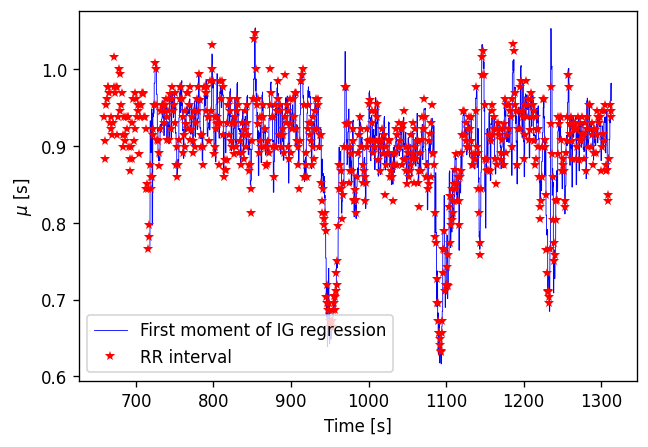

In [15]:
# Plot first moment of the distribution in time, along with the discrete RR intervals 
plt.figure(figsize=(6,4),dpi=120)
plt.plot(d["Time"],d["Mu"],"b",linewidth=0.5,label="First moment of IG regression")
plt.xlabel("Time [s]")
plt.ylabel("$\mu$ [s]")
plt.plot(rr[1:],np.diff(rr),"r*",mew=0.01,label="RR interval")
plt.legend()

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/var/folders/17/rqwtx3ln267d3s23tr72t9nh0000gn/T/ipykernel_59646/473054529.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(d["Time"],d["lambda"],"firebrick",linewidth=0.15,label="Hazard rate ($\lambda$)")
/var/folders/17/rqwtx3ln267d3s23tr72t9nh0000gn/T/ipykernel_59646/473054529.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("Hazard rate ($\lambda$)")
/var/folders/17/rqwtx3ln267d3s23tr72t9nh0000gn/T/ipykernel_59646/473054529.py:11: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(d["Time"][s:e],d["lambda"][s:e],"firebrick",linewidth=0.5,label="Hazard rate

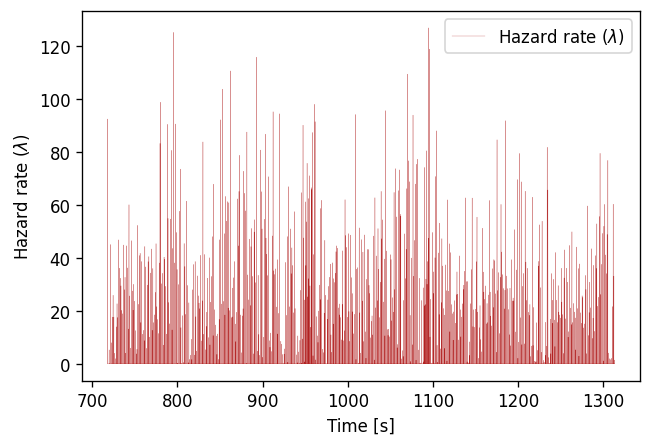

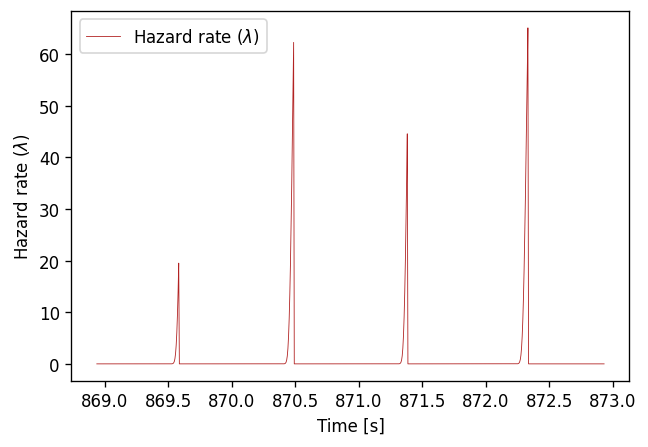

In [16]:
# Plot hazard rate
plt.figure(figsize=(6,4),dpi=120)
plt.plot(d["Time"],d["lambda"],"firebrick",linewidth=0.15,label="Hazard rate ($\lambda$)")
plt.xlabel("Time [s]")
plt.ylabel("Hazard rate ($\lambda$)")
plt.legend()

# Same but just for a smaller number of samples...
plt.figure(figsize=(6,4),dpi=120)
s,e = 30200,31000
plt.plot(d["Time"][s:e],d["lambda"][s:e],"firebrick",linewidth=0.5,label="Hazard rate ($\lambda$)")
plt.xlabel("Time [s]")
plt.ylabel("Hazard rate ($\lambda$)")
plt.legend()

Text(0.5, 0, 'Time [s]')

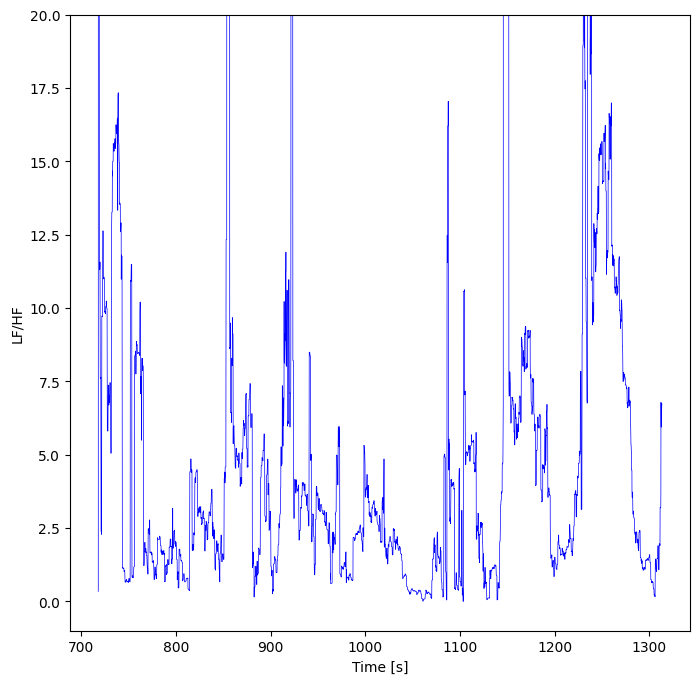

In [17]:
# Plot LF/HF ration
plt.figure(figsize=(8,8))
bal = d["powLF"] / d["powHF"]
plt.plot(d["Time"],bal,"blue",linewidth=0.5)
plt.ylim(-1,20)
plt.ylabel("LF/HF")
plt.xlabel("Time [s]")

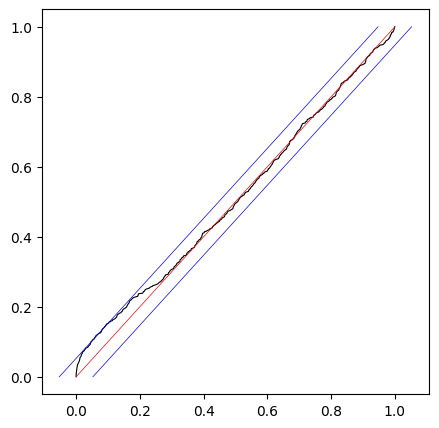

In [18]:
# Build KS plot to assess goodness of fit
coords = get_ks_coords(result.taus)
plt.figure(figsize=(5,5),dpi=100)
plt.plot(coords.z, coords.inner, "k", linewidth=0.8)
plt.plot(coords.lower, coords.inner, "b", linewidth=0.5)
plt.plot(coords.upper, coords.inner, "b", linewidth=0.5)
plt.plot(coords.inner, coords.inner, "r", linewidth=0.5)